# EDSR

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [37]:
!cp -R /content/gdrive/My\ Drive/weights /content

In [38]:
!cp -R /content/gdrive/My\ Drive/images /content

In [39]:
%tensorflow_version 1.x

In [40]:
from keras.layers import Add, Conv2D, Input, Lambda, Activation
from keras.models import Model
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

## Construct EDSR model

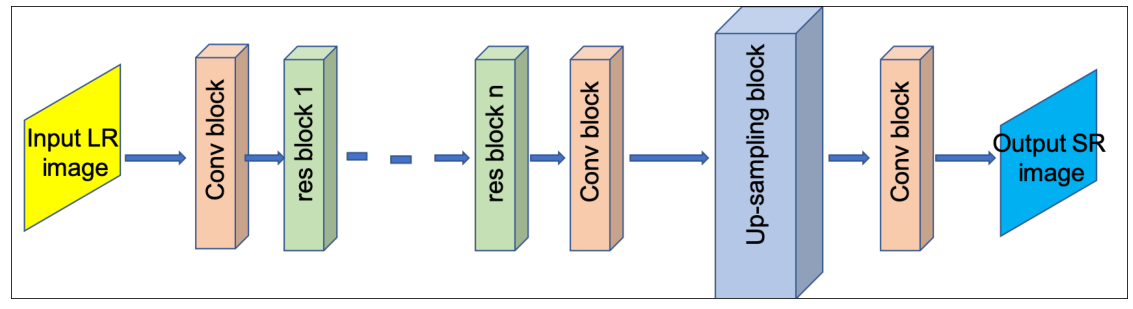

In [41]:
edsr_img = Image.open('/content/images/edsr_model.png')
plt.figure(figsize=(20, 15))
plt.xticks([])
plt.yticks([])
plt.imshow(edsr_img)

In [42]:
def edsr(scale, num_filters, num_res_blocks):
    x_in = Input(shape=(None, None, 3))
    x = Normalization()(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)
    x = Denormalization()(x)


    return Model(x_in, x, name="edsr")

In [43]:
def res_block(x_in, filters):
    x = Conv2D(filters, 3, padding='same')(x_in)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = Add()([x_in, x])
    return x

In [44]:
def upsample(x, scale, num_filters):
    def upsample_1(x, factor, name):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same')(x)
        return SubpixelConv2D(factor)(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

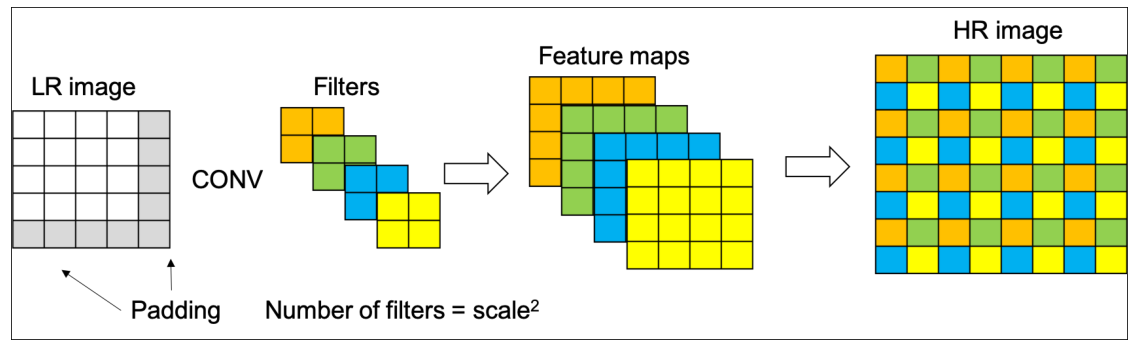

In [45]:
subp_img = Image.open('/content/images/sub_pixel.png')
plt.figure(figsize=(20, 15))
plt.xticks([])
plt.yticks([])
plt.imshow(subp_img)

In [46]:
def SubpixelConv2D(scale):
    return Lambda(lambda x: tf.depth_to_space(x, scale))

In [47]:
def Normalization(rgb_mean=DIV2K_RGB_MEAN):
    return Lambda(lambda x: (x - rgb_mean) / 127.5)

In [48]:
def Denormalization(rgb_mean=DIV2K_RGB_MEAN):
    return Lambda(lambda x: x * 127.5 + rgb_mean)

In [49]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4
num_filters=64

In [50]:
edsr_model = edsr(scale, num_filters, num_res_blocks=depth)

In [51]:
edsr_model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, None, None, 6 1792        lambda_5[0][0]                   
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, None, None, 6 36928       conv2d_38[0][0]                  
_______________________________________________________________________________________________

## Load pre-trained weights of EDSR

In [52]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

In [53]:
print(weights_file)

weights/edsr-16-x4/weights.h5


In [54]:
edsr_model.load_weights(weights_file)

### Create super resolution image

In [55]:
def load_image(path):
    return np.array(Image.open(path))

In [56]:
lr = load_image("/content/images/cal_plate-crop.jpeg")

In [57]:
lr.shape

(105, 89, 3)

In [58]:
def resolve(model, lr):
    sr = model.predict(np.expand_dims(lr, axis=0))[0]
    sr = np.clip(sr, 0, 255)
    sr = sr.astype('uint8')
    return sr

In [59]:
def plot_sample(lr, sr):
    plt.figure(figsize=(20, 10))

    images = [lr, sr]
    titles = ['LR', f'SR (x{sr.shape[0] // lr.shape[0]})']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [60]:
sr = resolve(edsr_model, lr)

In [61]:
sr.shape

(420, 356, 3)

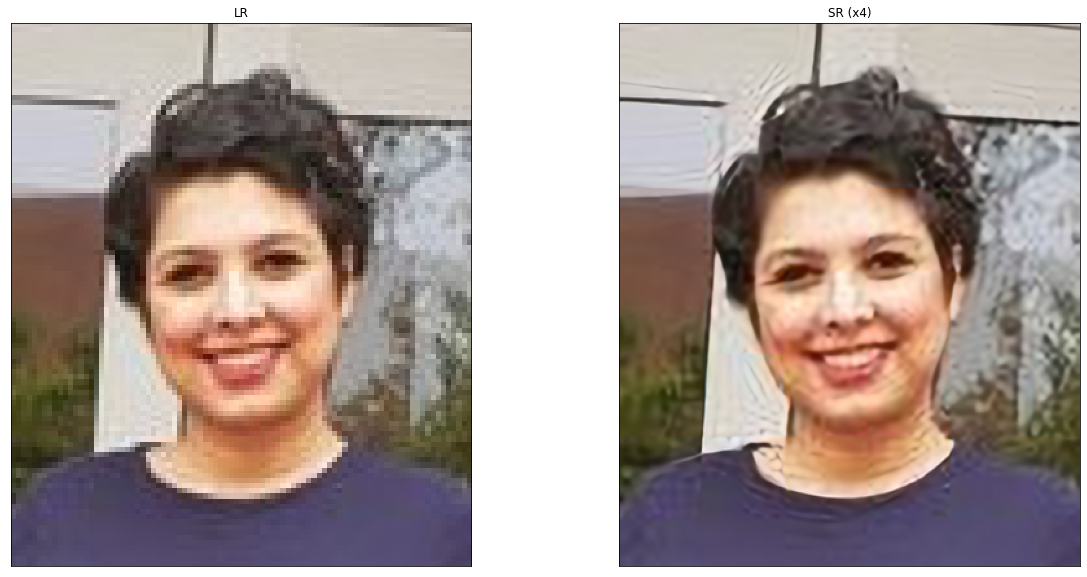

In [62]:
plot_sample(lr, sr)

In [79]:
from PIL import Image 
import PIL 

In [80]:
ab = Image.fromarray(sr)
ab.save('/content/gdrive/MyDrive/output/output.jpeg', format="JPEG")